# Semestrální práce
### Základem této práce jsou data eurostatu

### 1) Načtení dat a zobrazení první časové řady
##### Prvním krokem bylo načtení dat a zobrazení časové řady, abych se lépe seznámil s charakterem a chováním časové řady.

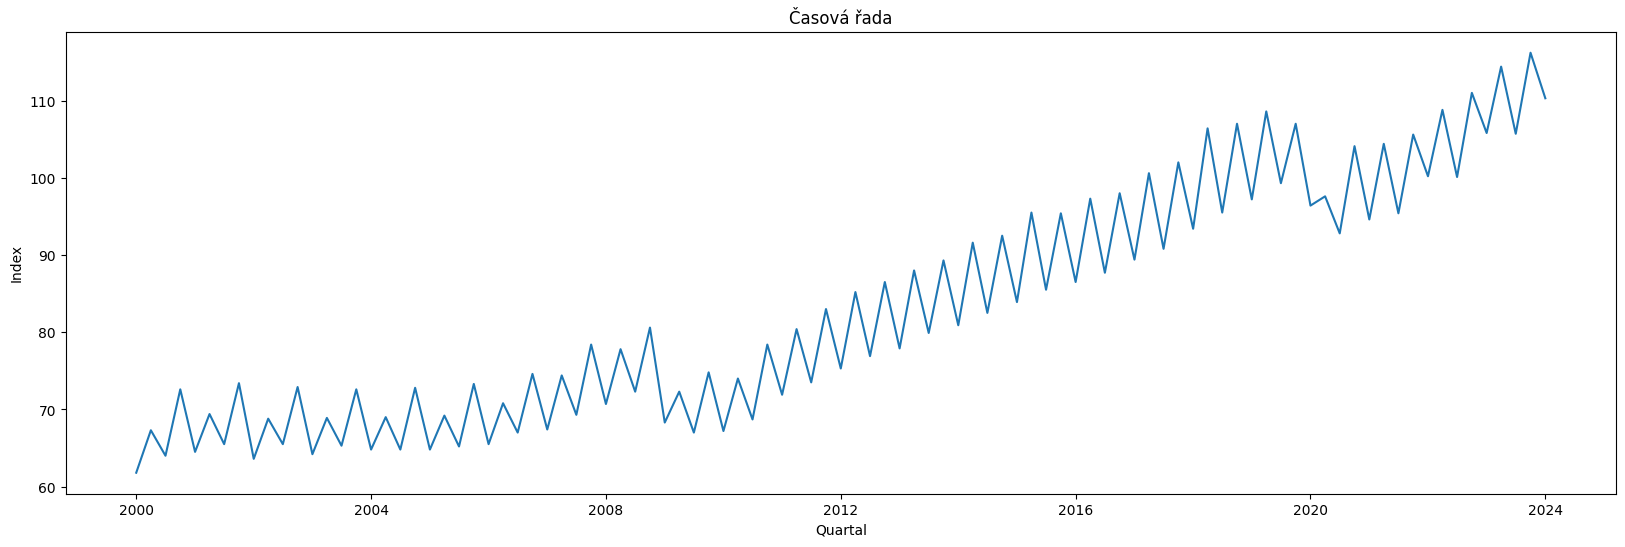

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings('ignore')


# Načtení dat z CSV souboru
data = pd.read_csv('ei_isind_q_linear.csv')

# Filtrování dat podle několika podmínek
filtered_data = data.loc[
    (data['unit'] == 'I21') & 
    (data['geo'] == 'DE') & 
    (data['s_adj'] == 'NSA') & 
    (data['indic_bt'] == 'WAGE') & 
    (data['nace_r2'] == 'C')
]

x = pd.to_datetime(filtered_data['TIME_PERIOD'])
y = filtered_data['OBS_VALUE']



plt.figure(figsize=(20, 6))
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.title("Časová řada")
plt.plot(x,y)



##### Po zobrazení časové řady si můžeme všimnout, že v různých obdobích se chování liší:
- První čeho si všímám - každá změna je jeden kvartál
    - Každý sudý vrchol je narůst a každý lichý je pokles, tedy data vypadají, že budou mít sezónní složku
- 2000-2004 -> Zde vidíme už okem, že se hodnoty přiliš nemění
- 2004-2008 -> Zde hodnoty začínají lehce stoupat
- 2008-2010 -> Zde došlu k většímu poklesu, než je obvyklé v předchozích obdobích
- 2010-2020 -> Zde až k roku 2020 hodnoty stále stoupají v podobném stylu
- 2020-konec -> Dochází k "výraznějšímu" poklesu a následně zase hodnoty stoupají

##### Trend se mi nezdá lineární, ale v následujícím kroku se na to podíváme detailněji

### 2) Dekompozice a identifikace trendu
##### Dekompozice časové řady slouží k rozkladu na tři hlavní složky (Trendová, sezónní a náhodná)

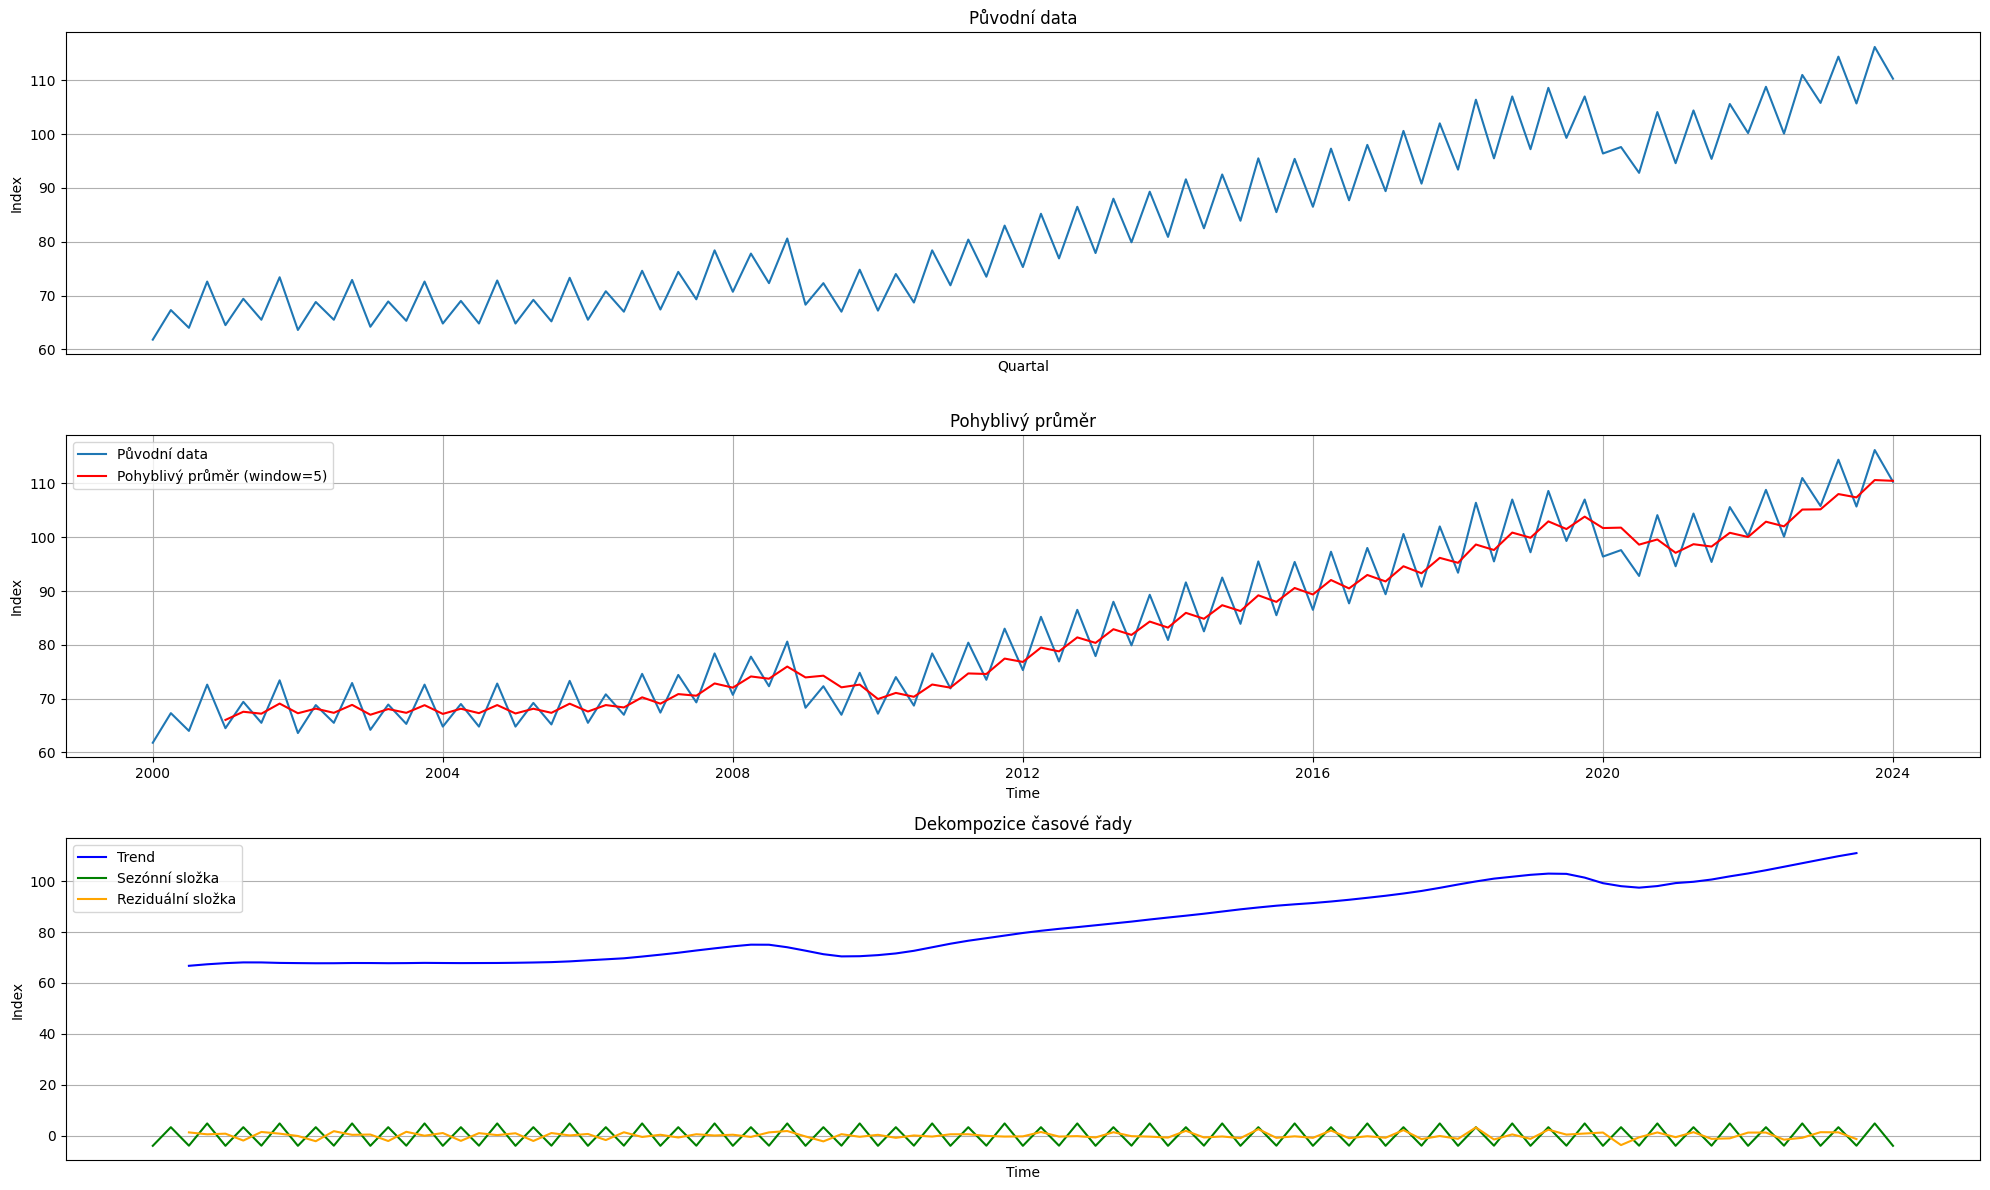

In [57]:
filtered_data['TIME_PERIOD'] = pd.to_datetime(filtered_data['TIME_PERIOD'])

# Nastavení sloupce s časem jako index
filtered_data.set_index('TIME_PERIOD', inplace=True)

# Ujistěte se, že data jsou seřazena podle času
filtered_data = filtered_data.sort_index()

# Výběr sloupce s hodnotami
data_values = filtered_data['OBS_VALUE']  # Upravte podle skutečného názvu sloupce s hodnotami

# Proveďte dekompozici
decomposition = seasonal_decompose(data_values, model='additive')

# Výpočet klouzavého průměru
window_size = 5
filtered_data['moving_average'] = filtered_data['OBS_VALUE'].rolling(window=window_size).mean()

# Zobrazení grafu
plt.figure(figsize=(20, 12))

# Původní data
plt.subplot(3, 1, 1)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.title('Původní data')
plt.ylabel('Index')
plt.xlabel('Quartal')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)

# Trend a klouzavý průměr
plt.subplot(3, 1, 2)
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], linestyle='-', label='Původní data')
plt.plot(filtered_data.index, filtered_data['moving_average'], linestyle='-', color='red', label=f'Pohyblivý průměr (window={window_size})')
plt.title('Pohyblivý průměr')
plt.ylabel('Index')
plt.xlabel('Time')
plt.grid(True)
plt.legend()

# Dekompozice
plt.subplot(3, 1, 3)
plt.plot(decomposition.trend, label='Trend', color='blue')
plt.plot(decomposition.seasonal, label='Sezónní složka', color='green')
plt.plot(decomposition.resid, label='Reziduální složka', color='orange')
plt.title('Dekompozice časové řady')
plt.ylabel('Index')
plt.xlabel('Time')
plt.xticks([])  # Odstranění hodnot na ose x
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

### Trend
##### Po dekompozici vidíme, že trendová složka je nelineární, ale z mého pohledu je stále stoupající až na občasné výkyvy.
### Sezónnost
#### Dle funkce, kterou zobrazuje sezónní složka se zdá, že data mají opravdu sezónní složku, která má tendenci v lichých bodech klesat a v sudých bodech stoupat (Sudá a Lichá záleží od toho, kde začneme)
### Náhodná složka
##### I tato složka se vyskytuje, ačkoliv velmi málo



### 3) Hledání optimálního modelu pro časovou řadu
##### Dle poznatků, ke kterým jsem došel v předchozích bodech si myslím, že nejvhdonější model pro modelování a predikci bude SARIMA, jelikož se zde vyskytuje sezónnost

##### Ale pojďme vyzkoušet k čemu dojdeme při modelování

#### a) Lineární regrese

##### Lineární regrese je jeden z nejjednoduších přístupů a používá se jako jeden z prvních kroků k získání chování trendu

##### Pro determinaci validity modelu využijeme koeficient determinace, který určuje hodnoty od 0-1, přicemž 1 je nejlepší možná hodnota. Tato hodnota se tvoří pomocí metody nejmenších čtverců.

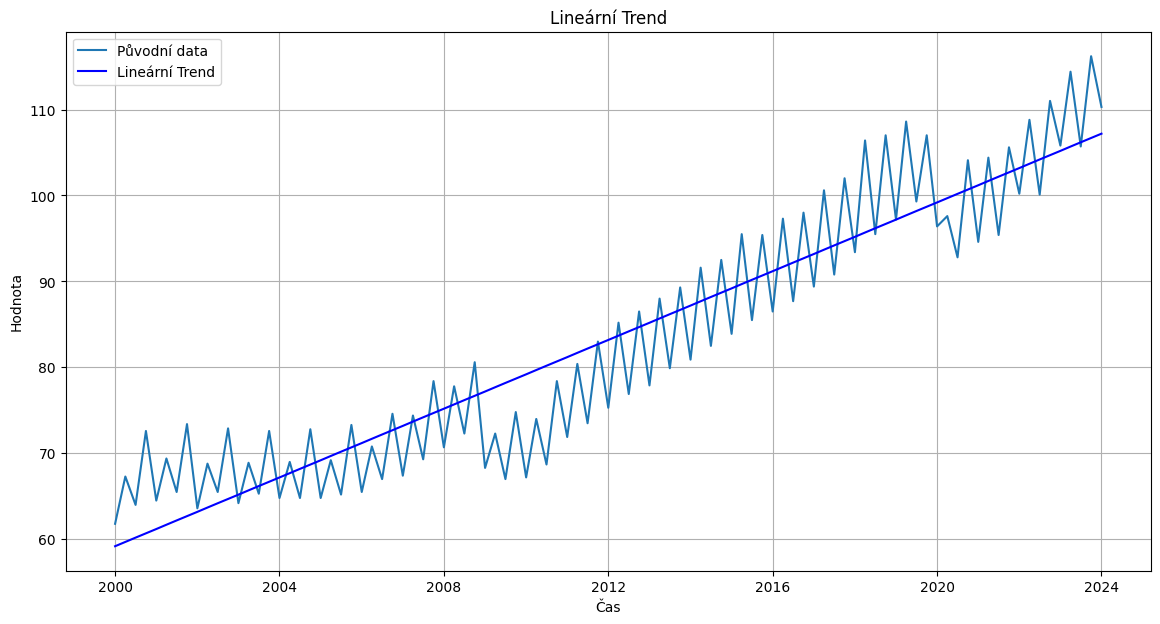

Koeficient Determinace (R²): 0.8601


In [58]:
filtered_data['Time'] = np.arange(len(filtered_data))

model = LinearRegression()
model.fit(filtered_data[['Time']], filtered_data['OBS_VALUE'])
filtered_data['Trend'] = model.predict(filtered_data[['Time']])

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(filtered_data.index, filtered_data['Trend'], color='blue', label='Lineární Trend')
plt.title('Lineární Trend')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Zhodnocení modelu
r_squared = r2_score(filtered_data['OBS_VALUE'], filtered_data['Trend'])
print(f'Koeficient Determinace (R²): {r_squared:.4f}')


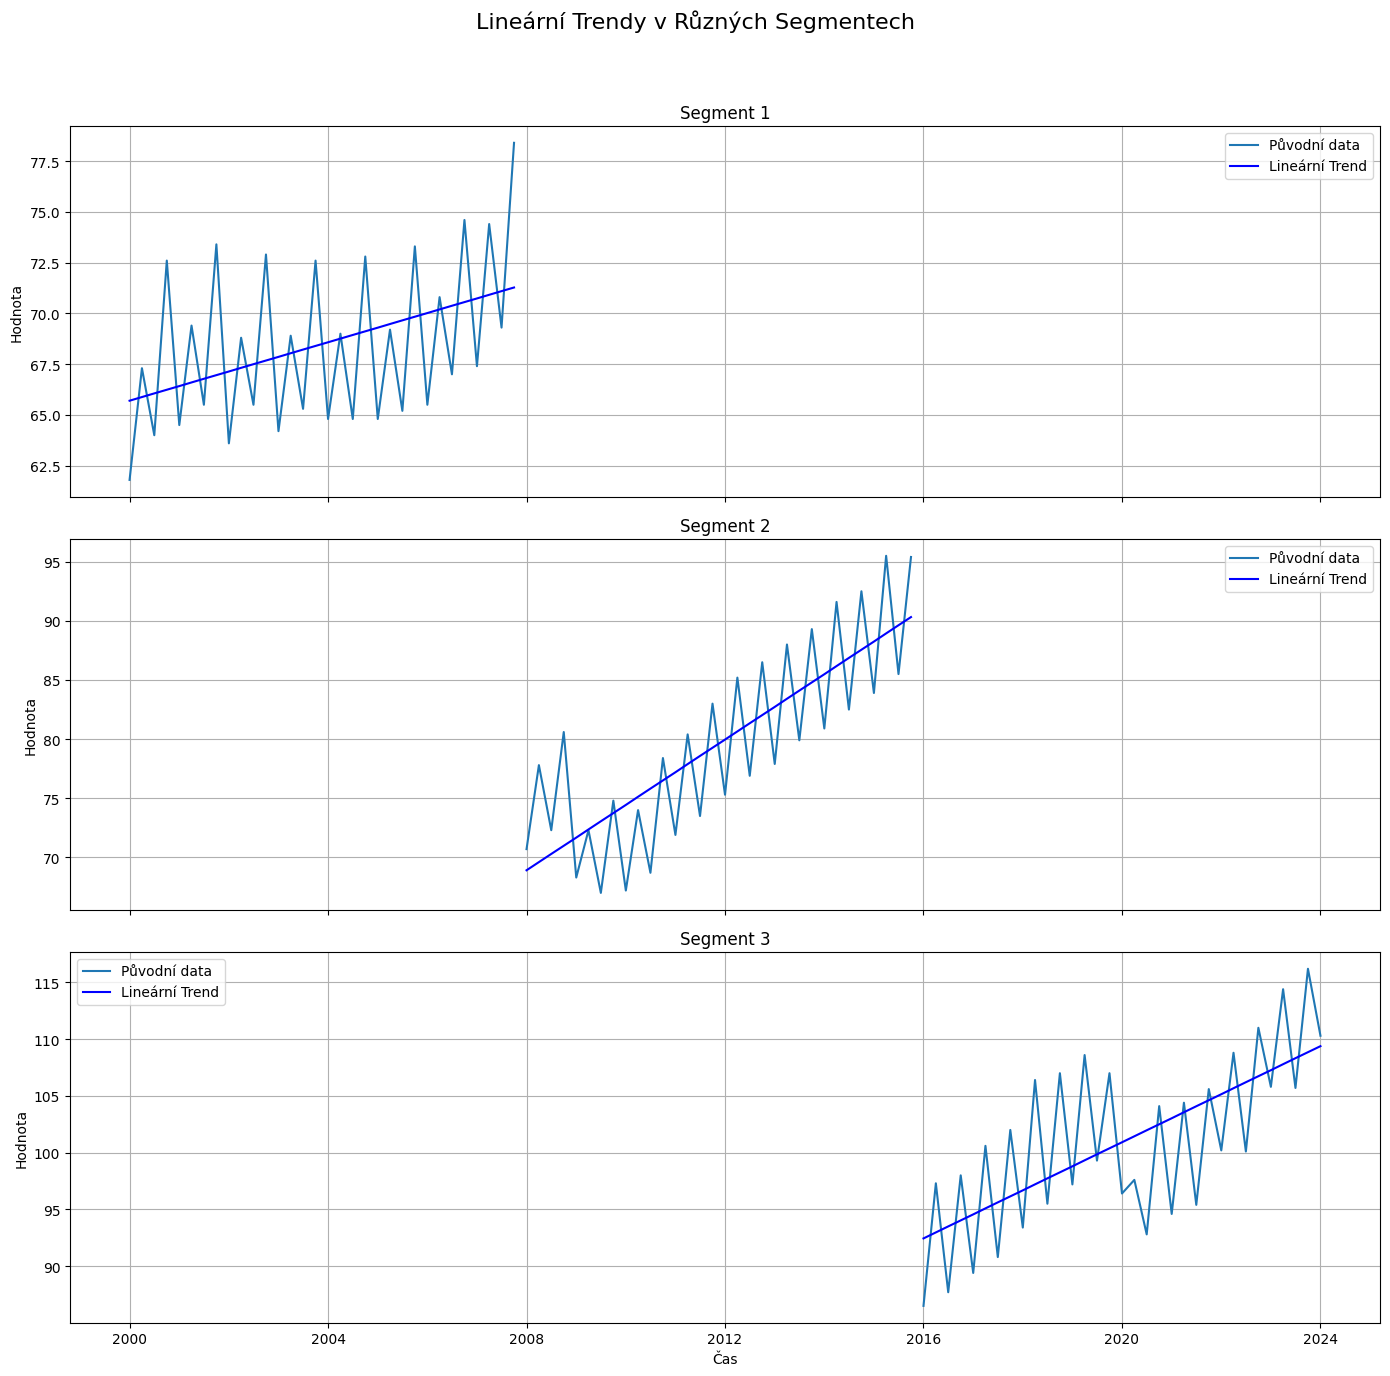

Koeficient Determinace (R²) Segmentu 1: 0.1716
Koeficient Determinace (R²) Segmentu 2: 0.6309
Koeficient Determinace (R²) Segmentu 3: 0.4575


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Rozdělení dat na tři segmenty
num_segments = 3
segment_size = len(filtered_data) // num_segments
segments = [filtered_data.iloc[i*segment_size:(i+1)*segment_size] for i in range(num_segments)]

# Případně zahrneme zbytek, pokud počet dat není dělitelný třemi
if len(filtered_data) % num_segments != 0:
    segments[-1] = filtered_data.iloc[(num_segments-1)*segment_size:]

# Příprava figure s 3 podgrafy
fig, axs = plt.subplots(num_segments, 1, figsize=(14, 14), sharex=True)
fig.suptitle('Lineární Trendy v Různých Segmentech', fontsize=16)

# Modelování trendu pro každý segment a vykreslení
for i, segment in enumerate(segments):
    model = LinearRegression()
    model.fit(segment[['Time']], segment['OBS_VALUE'])
    segment['Trend'] = model.predict(segment[['Time']])
    
    axs[i].plot(segment.index, segment['OBS_VALUE'], label='Původní data')
    axs[i].plot(segment.index, segment['Trend'], color='blue', label='Lineární Trend')
    axs[i].set_title(f'Segment {i + 1}')
    axs[i].set_ylabel('Hodnota')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].set_xlabel('Čas')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make space for suptitle
plt.show()

# Zhodnocení modelů
r_squared_values = []
for i, segment in enumerate(segments):
    r_squared = r2_score(segment['OBS_VALUE'], segment['Trend'])
    r_squared_values.append(r_squared)
    print(f'Koeficient Determinace (R²) Segmentu {i + 1}: {r_squared:.4f}')

##### Po zobrazení trendu a vypsání hodnoty R**2 si dovolím potvrdit, že trend je opravdu vzestupný a můžeme tomu věřit. 

#### b) ARIMA

##### V tomto kroku si vyzkoušíme predikovat hodnoty pomocí ARIMA modelu, který by ale dle vlastností modelu neměl být užit, jelikož se v našich datech objevuje sezónní složka. 

##### Pro zhodnocení modelu využijeme AIC a BIC, které zhodnocují kvalitu i složitost modelu. Zde naopak chceme dosáhnout co nejmenších hodnot.

###### Nižší hodnota AIC naznačuje lepší model, protože model minimalizuje ztrátu informací.

###### Nižší hodnota BIC také signalizuje lepší model, ale penalizace za složitost modelu je silnější než u AIC.


|   iter    |  target   |     d     |     p     |     q     |
-------------------------------------------------------------
| 1         | -407.2    | 2.085     | 3.602     | 0.0005719 |
| 2         | -681.0    | 1.512     | 0.7338    | 0.4617    |
| 3         | -617.3    | 0.9313    | 1.728     | 1.984     |
| 4         | -423.0    | 2.694     | 2.096     | 3.426     |
| 5         | -403.3    | 1.022     | 4.391     | 0.1369    |
| 6         | -475.5    | 3.352     | 2.087     | 2.793     |
| 7         | -601.5    | 0.7019    | 0.9905    | 4.004     |
| 8         | -489.8    | 4.841     | 1.567     | 3.462     |
| 9         | -517.9    | 4.382     | 4.473     | 0.4252    |
| 10        | -601.5    | 0.1953    | 0.8492    | 4.391     |
| 11        | -397.4    | 2.889     | 3.852     | 4.483     |
| 12        | -407.0    | 1.726     | 5.0       | 2.568     |
| 13        | -416.5    | 0.3027    | 5.0       | 5.0       |
| 14        | -451.4    | 5.0       | 5.0       | 5.0       |
| 15    

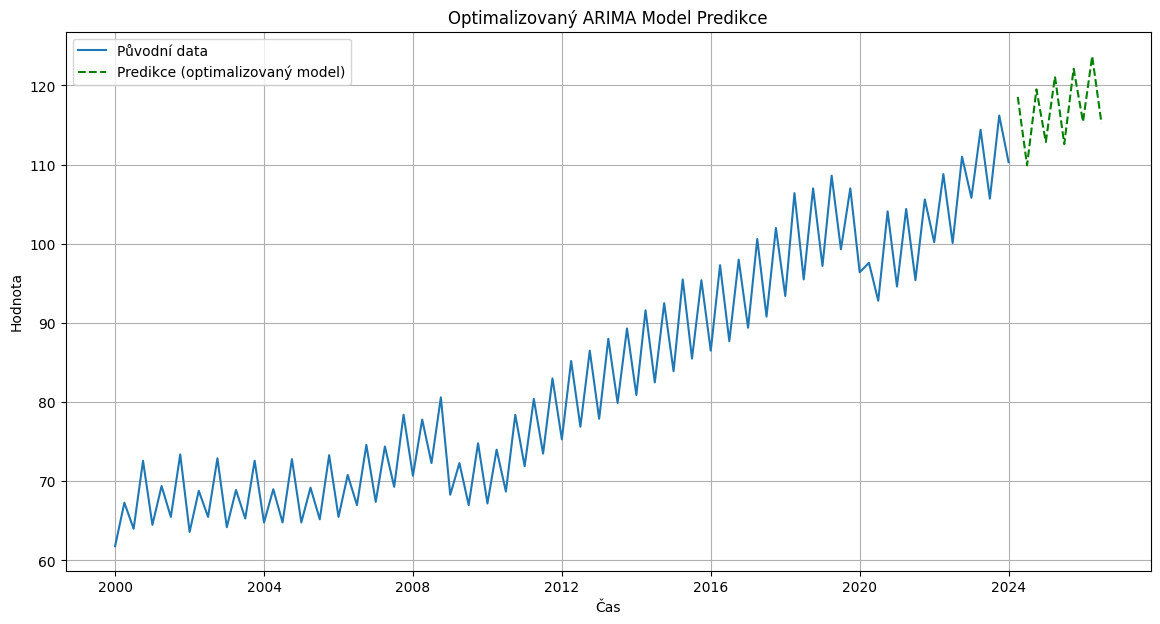

AIC: 397.4205004850135
BIC: 417.8515156178178


In [33]:
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

forecast_periods = 10
# Funkce pro hodnocení ARIMA modelu (AIC jako metrika)
def evaluate_arima_model(data, p, d, q):
    try:
        # Převod parametrů na celočíselné hodnoty
        p, d, q = int(p), int(d), int(q)
        
        # Vytvoření a fitování ARIMA modelu
        model = ARIMA(data, order=(p, d, q))
        model_fit = model.fit()
        
        # Návrat hodnoty AIC
        return -model_fit.aic  # Optimalizujeme na minimum, takže vracíme zápornou hodnotu
    except:
        return np.inf  # Pokud model selže, vracíme nekonečno

# Definování rozsahu parametrů
pbounds = {
    'p': (0, 5),
    'd': (0, 5),
    'q': (0, 5)
}

# Spuštění Bayesian Optimization
optimizer = BayesianOptimization(
    f=lambda p, d, q: evaluate_arima_model(filtered_data['OBS_VALUE'], p, d, q),
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

# Spuštění optimalizace (např. 50 pokusů)
optimizer.maximize(init_points=10, n_iter=40)

# Nejlepší nalezené parametry
best_params = optimizer.max['params']
p_best = int(best_params['p'])
d_best = int(best_params['d'])
q_best = int(best_params['q'])

print(f'Nejlepší parametry ARIMA: p={p_best}, d={d_best}, q={q_best}')

# Trénink modelu ARIMA s optimalizovanými parametry
best_model = ARIMA(filtered_data['OBS_VALUE'], order=(p_best, d_best, q_best))
best_model_fit = best_model.fit()

# Vytvoření predikcí
forecast = best_model_fit.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=forecast_periods, freq='Q')

# Vykreslení výsledků
plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(forecast_index, forecast, color='green', linestyle='--', label='Predikce (optimalizovaný model)')
plt.title('Optimalizovaný ARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Zobrazení AIC a BIC pro optimalizovaný model
print(f'AIC: {best_model_fit.aic}')
print(f'BIC: {best_model_fit.bic}')

##### Po modelování a predikci okem vidíme, že hodnoty stále sotupají, ale už ne tolik jako předtím. 

##### Hodnoty:
- AIC: 403
- BIC: 421

#### 4) Použití SARIMA modelu

##### V dalším kroku využijeme SARIMA modelu, který už bere v potaz sezónní složku

##### Kritéria pro vyhodnocení budou zase AIC a BIC

|   iter    |  target   |     D     |     P     |     Q     |     d     |     p     |     q     |     s     |
-------------------------------------------------------------------------------------------------------------
| 1         | -470.9    | 2.089     | 0.8584    | 0.6806    | 1.654     | 2.158     | 1.269     | 4.0       |
| 2         | -391.8    | 2.054     | 1.443     | 1.176     | 1.03      | 2.187     | 1.316     | 4.0       |
| 3         | -382.6    | 1.194     | 2.214     | 0.5475    | 0.5264    | 1.595     | 1.595     | 4.0       |
| 4         | -389.0    | 2.548     | 2.173     | 1.833     | 2.167     | 0.9689    | 1.085     | 4.0       |
| 5         | -400.5    | 0.8811    | 1.893     | 0.2763    | 1.301     | 1.293     | 1.481     | 4.0       |
| 6         | -463.5    | 0.9368    | 1.279     | 2.68      | 2.832     | 1.506     | 1.872     | 4.0       |
| 7         | -416.0    | 0.9519    | 1.244     | 2.599     | 0.7514    | 1.449     | 2.957     | 4.0       |
| 8       

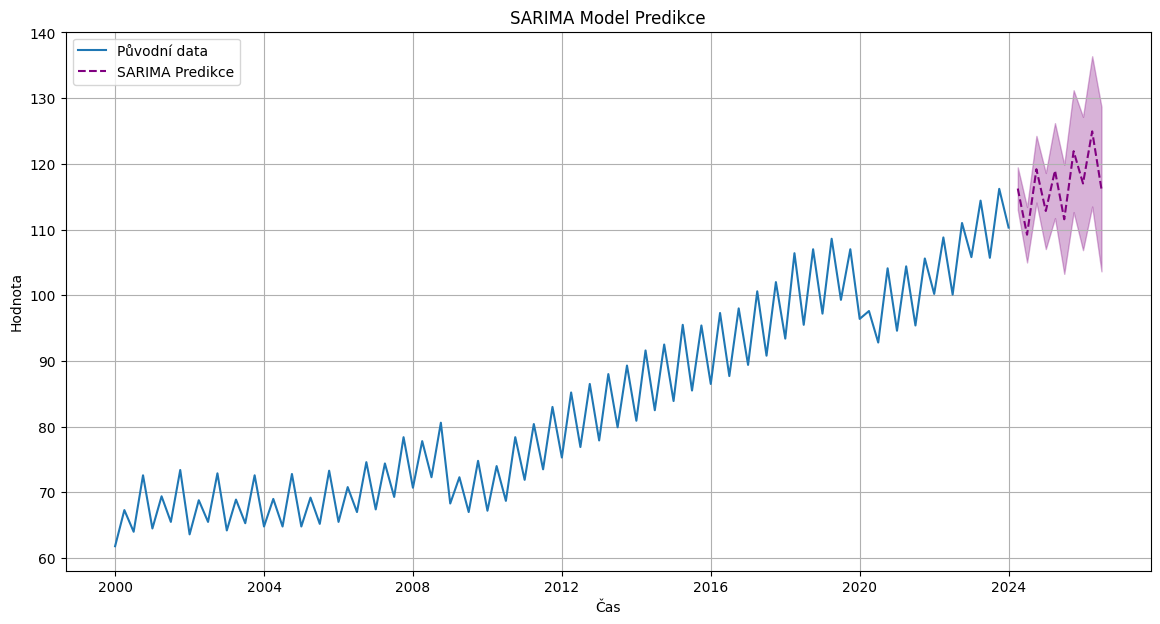

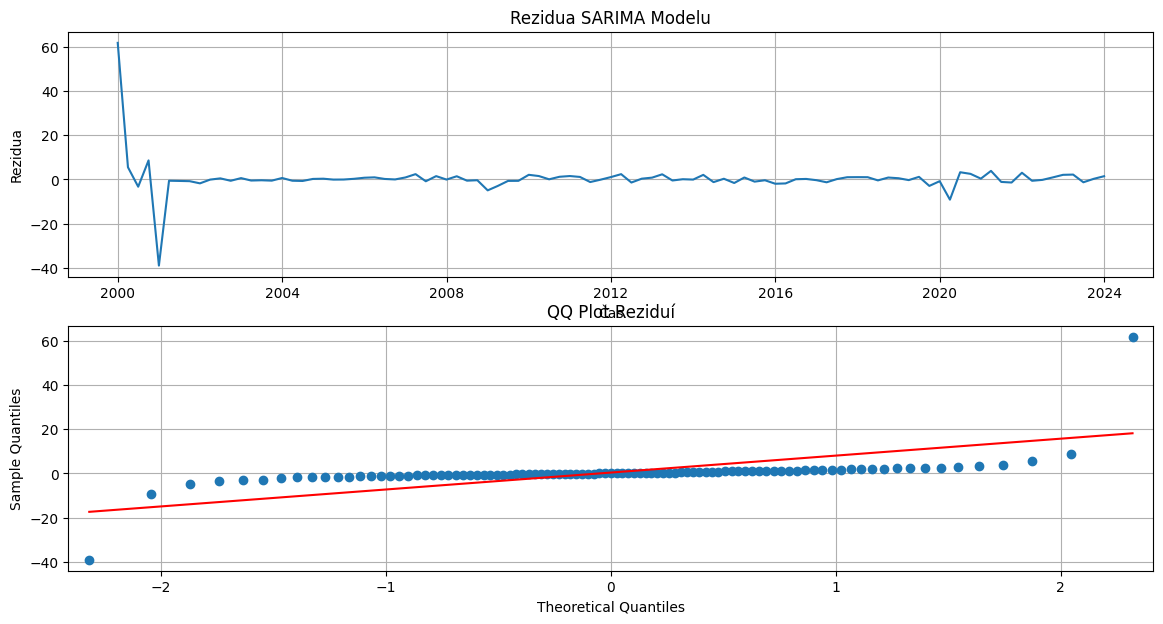

AIC: 373.68577902890524
BIC: 388.8165104911995


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def evaluate_sarima_model(data, p, d, q, P, D, Q, s):
    order = (int(p), int(d), int(q))
    seasonal_order = (int(P), int(D), int(Q), int(s))
    try:
        model = SARIMAX(data, order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        aic = model_fit.aic
        return -aic  # BayesianOptimization minimalizuje funkci, proto vracíme negativní AIC
    except Exception as e:
        print(f"Chyba při trénování modelu SARIMA s parametry {order} a {seasonal_order}: {e}")
        return np.nan

# Definuj rozsahy hyperparametrů
pbounds = {
    'p': (0, 3),
    'd': (0, 3),
    'q': (0, 3),
    'P': (0, 3),
    'D': (0, 3),
    'Q': (0, 3),
    's': (4, 4)  # Pokud je sezónní cyklus fixní, jinak specifikuj rozmezí
}

# Bayesian optimization
optimizer = BayesianOptimization(
    f=lambda p, d, q, P, D, Q, s: evaluate_sarima_model(filtered_data['OBS_VALUE'], p, d, q, P, D, Q, s),
    pbounds=pbounds,
    verbose=2,
    random_state=123
)

optimizer.maximize(init_points=10, n_iter=100)

# Nejlepší parametry
best_params = optimizer.max['params']
print(f'Nejlepší parametry: {best_params}')

# Trénování SARIMA modelu s nejlepšími parametry
best_order = (int(best_params['p']), int(best_params['d']), int(best_params['q']))
best_seasonal_order = (int(best_params['P']), int(best_params['D']), int(best_params['Q']), int(best_params['s']))

sarima_model = SARIMAX(
    filtered_data['OBS_VALUE'],
    order=best_order,
    seasonal_order=best_seasonal_order
)
sarima_model_fit = sarima_model.fit()

# Predikce s SARIMA modelem
sarima_forecast = sarima_model_fit.get_forecast(steps=10)
sarima_forecast_index = pd.date_range(start=filtered_data.index[-1] + pd.DateOffset(months=1), periods=10, freq='Q')
sarima_forecast_conf_int = sarima_forecast.conf_int()

plt.figure(figsize=(14, 7))
plt.plot(filtered_data.index, filtered_data['OBS_VALUE'], label='Původní data')
plt.plot(sarima_forecast_index, sarima_forecast.predicted_mean, color='purple', linestyle='--', label='SARIMA Predikce')
plt.fill_between(sarima_forecast_index, sarima_forecast_conf_int.iloc[:, 0], sarima_forecast_conf_int.iloc[:, 1], color='purple', alpha=0.3)
plt.title('SARIMA Model Predikce')
plt.xlabel('Čas')
plt.ylabel('Hodnota')
plt.legend()
plt.grid(True)
plt.show()

# Rezidua a QQ plot
residuals = sarima_model_fit.resid
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(residuals)
plt.title('Rezidua SARIMA Modelu')
plt.xlabel('Čas')
plt.ylabel('Rezidua')
plt.grid(True)

plt.subplot(2, 1, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ Plot Reziduí')
plt.grid(True)
plt.show()

print(f'AIC: {sarima_model_fit.aic}')
print(f'BIC: {sarima_model_fit.bic}')

In [53]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f'Durbin-Watson test statistic: {dw_stat}')

from scipy.stats import shapiro
shapiro_test = shapiro(residuals)
print(f'Shapiro-Wilk test p-hodnota: {shapiro_test.pvalue}')

from statsmodels.stats.diagnostic import acorr_ljungbox
i = 1
for i in range(i,25):
    lb_test = acorr_ljungbox(residuals, lags=[i], return_df=True)
    print(lb_test)

Durbin-Watson test statistic: 1.3361519045535868
Shapiro-Wilk test p-hodnota: 6.862420856317103e-19
    lb_stat  lb_pvalue
1  0.000044   0.994696
    lb_stat  lb_pvalue
2  0.001762    0.99912
    lb_stat  lb_pvalue
3  0.368804   0.946609
     lb_stat  lb_pvalue
4  18.029049   0.001218
     lb_stat  lb_pvalue
5  18.036552   0.002901
     lb_stat  lb_pvalue
6  18.054724   0.006097
     lb_stat  lb_pvalue
7  18.071924    0.01165
     lb_stat  lb_pvalue
8  18.139092   0.020208
     lb_stat  lb_pvalue
9  18.139425    0.03359
      lb_stat  lb_pvalue
10  18.146388   0.052544
      lb_stat  lb_pvalue
11  18.153144   0.078094
      lb_stat  lb_pvalue
12  18.153651   0.111104
      lb_stat  lb_pvalue
13  18.153681   0.151771
      lb_stat  lb_pvalue
14  18.153835   0.199864
     lb_stat  lb_pvalue
15  18.16368   0.254158
      lb_stat  lb_pvalue
16  18.166623   0.314231
      lb_stat  lb_pvalue
17  18.172011   0.378068
      lb_stat  lb_pvalue
18  18.181126   0.443782
      lb_stat  lb_pvalue
1

##### Jak vidíme po výpisu, tak dle hodnot AIC a BIC by tento model měl být lepší, což potvrzuje vhodnost modelu. 

##### Hodnoty:
- AIC: 373
- BIC: 386


##### Tedy dle mého názoru je zde optimální model SARIMA

# 5) Kroskorelace a srovnání modelů

##### V posledním kroku provedeme kroskorelaci pro různé státy, abychom zjistili, zda jsou různé časové řady navzájem propojené.

##### Pomocí kroskorelace můžeme zjistit, zda změny v jedné časové řadě ovlivňují změny v druhé časové řadě a jaký časový posun má největší vliv

##### Následně provedeme srovnání modelů pro různé státy.

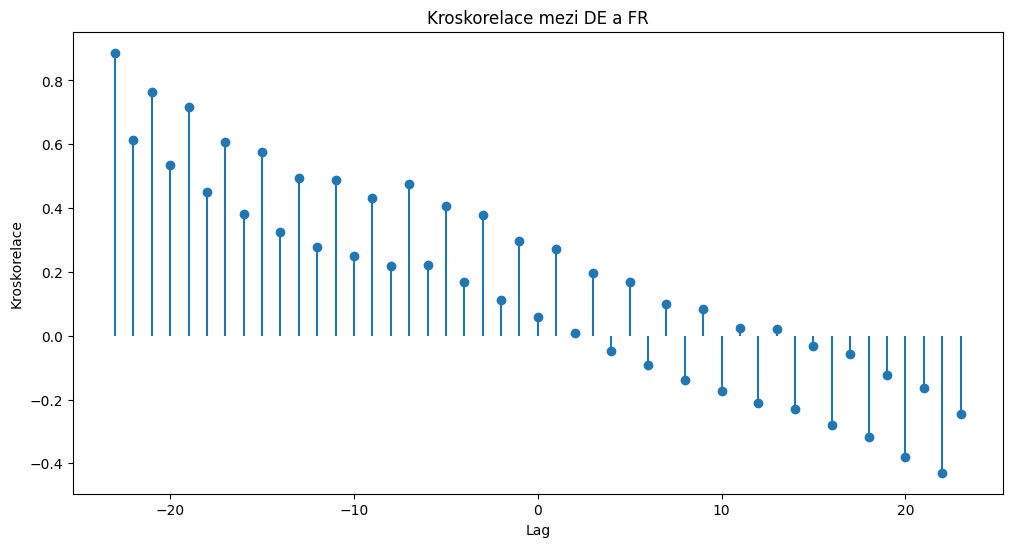

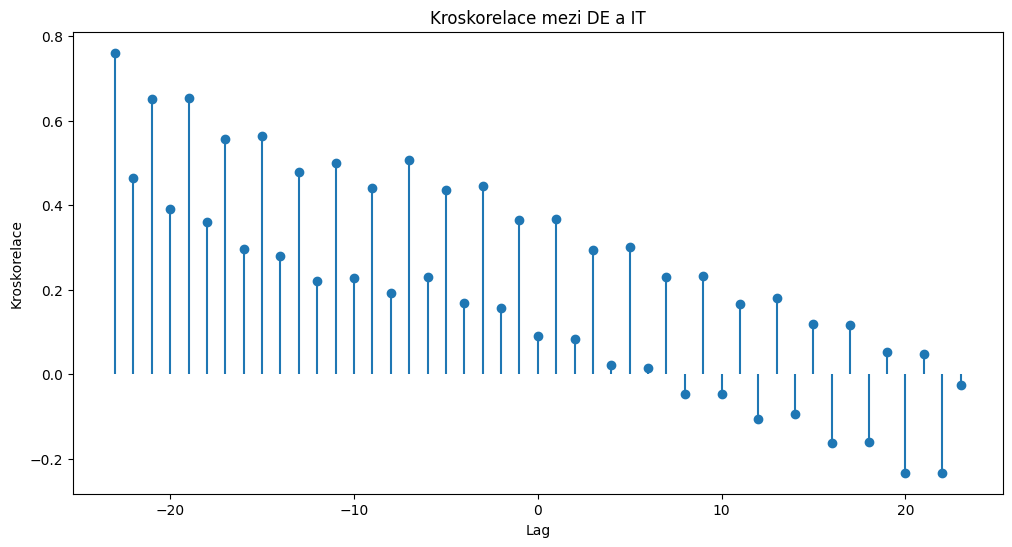

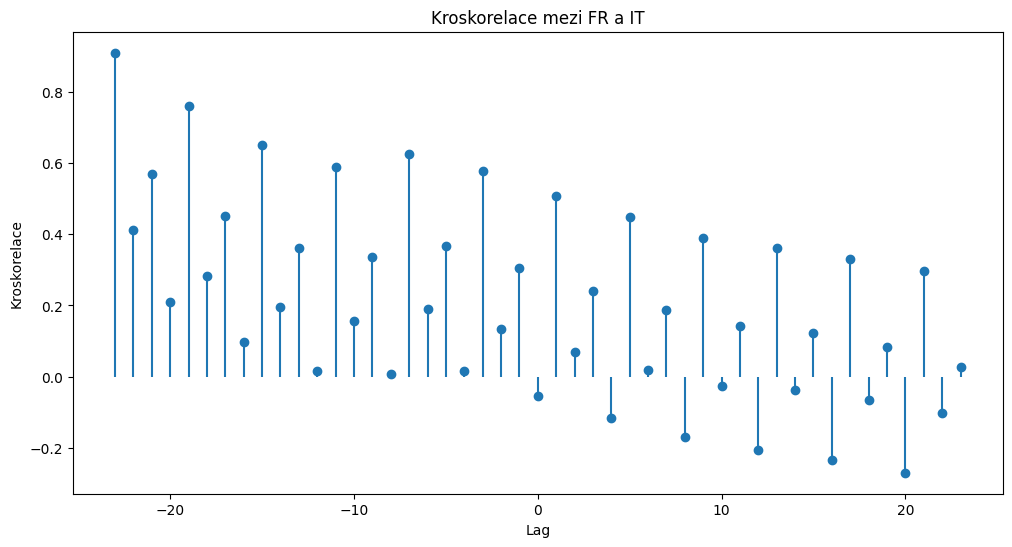

     arima_aic   arima_bic  sarima_aic  sarima_bic
DE  404.758205  432.966035  376.595959  389.204902
FR  433.166467  461.374297  401.603744  414.212686
IT  494.854999  523.062829  455.666017  468.274960


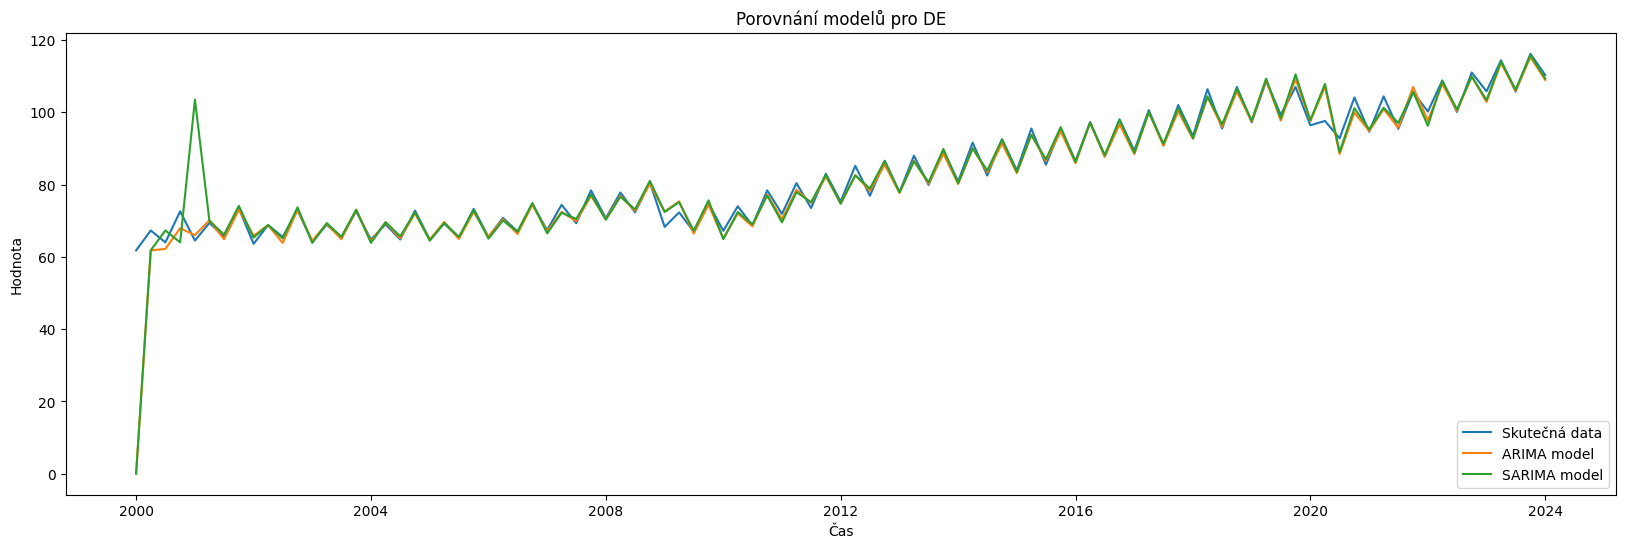

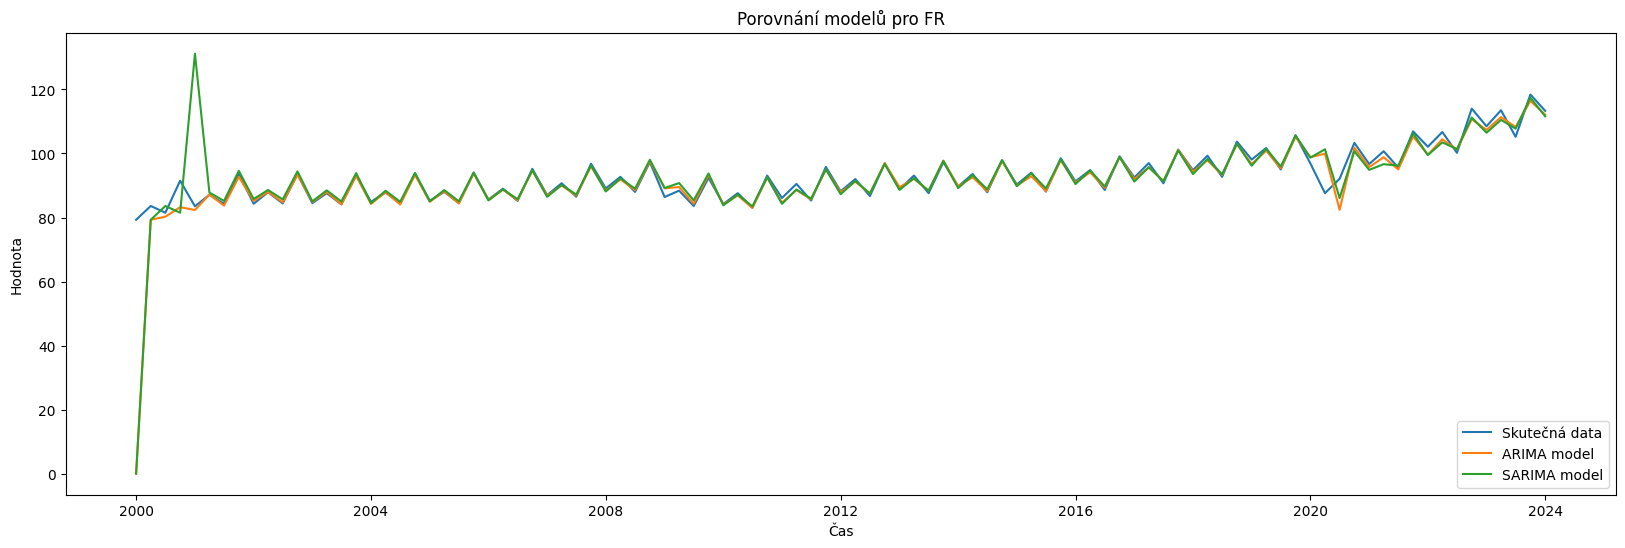

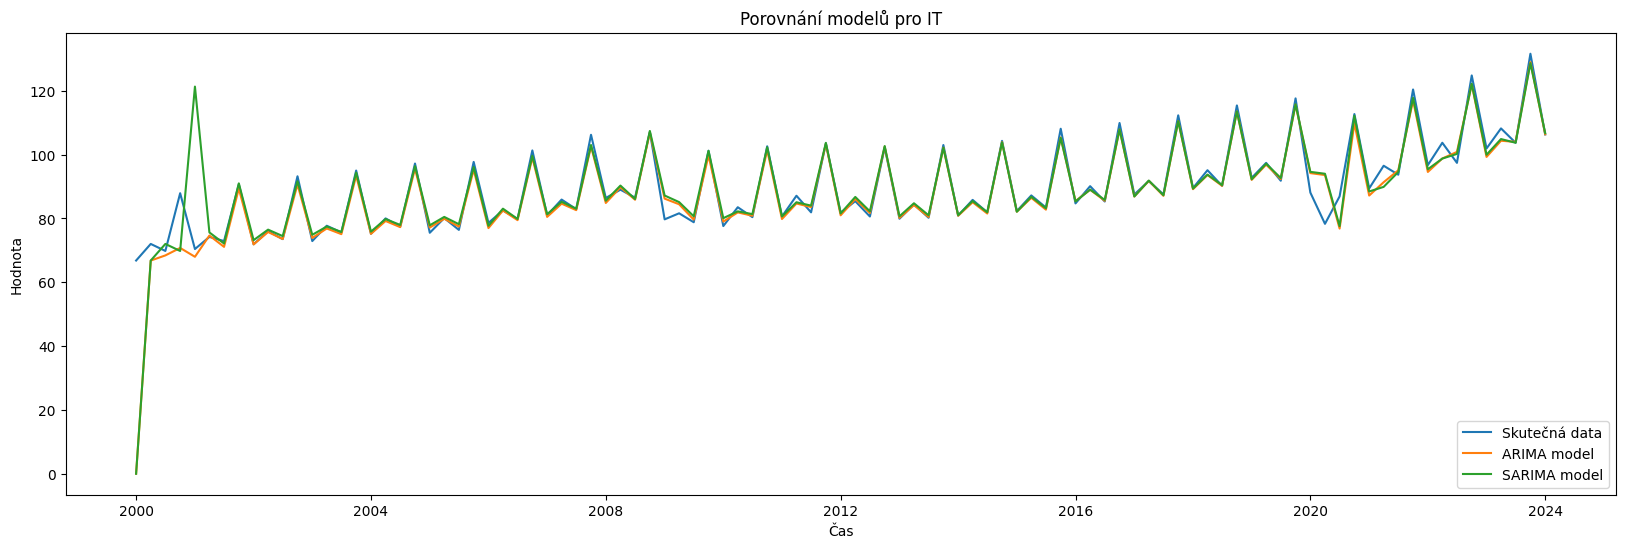

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import ParameterGrid

# Načtení původních dat
data = pd.read_csv('ei_isind_q_linear.csv')

data.index.freq = 'Q'
# Seznam geografických označení, které chcete analyzovat
geos = ['DE', 'FR', 'IT']  # Příklad

# Načtení a sloučení dat pro všechny geografické oblasti
all_filtered_data = []
for geo in geos:
    filtered_data = data.loc[
        (data['unit'] == 'I21') & 
        (data['geo'] == geo) & 
        (data['s_adj'] == 'NSA') & 
        (data['indic_bt'] == 'WAGE') & 
        (data['nace_r2'] == 'C')
    ].copy()  # Použití copy(), aby se zabránilo varování
    filtered_data.loc[:, 'geo'] = geo  # Použití .loc pro přiřazení
    all_filtered_data.append(filtered_data)

combined_data = pd.concat(all_filtered_data)

# Převedení TIME_PERIOD na datetime
combined_data['TIME_PERIOD'] = pd.to_datetime(combined_data['TIME_PERIOD'])

# Pivotování dat na formát, který umožňuje analýzu
pivot_data = combined_data.pivot(index='TIME_PERIOD', columns='geo', values='OBS_VALUE')

# Kroskorelace mezi různými geografickými oblastmi
def compute_ccf(series1, series2, max_lag):
    """Compute cross-correlation function values up to a maximum lag."""
    common_dates = series1.index.intersection(series2.index)
    series1 = series1.loc[common_dates]
    series2 = series2.loc[common_dates]
    ccf_values = ccf(series1, series2)
    return ccf_values[:2 * max_lag + 1]

# Použití funkce compute_ccf pro kroskorelaci
geo_pairs = [('DE', 'FR'), ('DE', 'IT'), ('FR', 'IT')]

for geo1, geo2 in geo_pairs:
    series1 = pivot_data[geo1].dropna()
    series2 = pivot_data[geo2].dropna()
    
    if len(series1) > 1 and len(series2) > 1:
        max_lag = 23 # Definujte maximální lag
        ccf_values = compute_ccf(series1, series2, max_lag)
        plt.figure(figsize=(12, 6))
        plt.stem(range(-max_lag, max_lag + 1), ccf_values, basefmt=" ")
        plt.title(f'Kroskorelace mezi {geo1} a {geo2}')
        plt.xlabel('Lag')
        plt.ylabel('Kroskorelace')
        plt.show()
    else:
        print(f'Příliš krátká série pro kroskorelaci mezi {geo1} a {geo2}')

# Funkce pro automatické modelování ARIMA
def fit_arima(series, p=5, d=1, q=5):
    model = ARIMA(series, order=(p, d, q))
    result = model.fit()
    return result

# Funkce pro automatické modelování SARIMA
def fit_sarima(series, p=1, d=1, q=1, seasonal_p=1, seasonal_d=1, seasonal_q=1, s=4):
    model = SARIMAX(series, order=(p, d, q), seasonal_order=(seasonal_p, seasonal_d, seasonal_q, s))
    result = model.fit()
    return result

# Fit ARIMA a SARIMA modely pro každou geografickou oblast
results = {}
for geo in geos:
    series = pivot_data[geo].dropna()
    
    # Fit modelů
    arima_model = fit_arima(series)
    sarima_model = fit_sarima(series)
    
    # Uložení výsledků
    results[geo] = {
        'arima_aic': arima_model.aic,
        'arima_bic': arima_model.bic,
        'sarima_aic': sarima_model.aic,
        'sarima_bic': sarima_model.bic
    }

results_df = pd.DataFrame(results).T
results_df.sort_values(by=['arima_aic', 'sarima_aic'], ascending=True, inplace=True)
print(results_df)

# Vizualizace predikcí pro jednotlivé modely
for geo in geos:
    series = pivot_data[geo].dropna()
    
    # Fit modelů
    arima_model = fit_arima(series)
    sarima_model = fit_sarima(series)
    
    # Predikce a fitování
    arima_pred = arima_model.fittedvalues
    sarima_pred = sarima_model.fittedvalues
    
    plt.figure(figsize=(20, 6))
    plt.plot(series, label='Skutečná data')
    plt.plot(pd.Series(arima_pred, index=series.index), label='ARIMA model')
    plt.plot(pd.Series(sarima_pred, index=series.index), label='SARIMA model')
    plt.legend()
    plt.title(f'Porovnání modelů pro {geo}')
    plt.xlabel('Čas')
    plt.ylabel('Hodnota')
    plt.show()
    
    

##### Dle kroskorelace vidíme, že největší vztah:
- pro DE a FR/IT -> zpoždění -20
- pro FR a IT -> zpoždění v -20

##### Z výpisu vidíme jak se oproti sobě liší skutečná data a ARIMA/SARIMA model, na vizualizaci není moc vidět jaký model je lepší, ale hodnoty SARIMA/ARIMA AIC a BIC jsou vždy lepší pro SARIMA model. 

In [25]:
from statsmodels.tsa.api import VAR

def lag_order_test(data, max_lags=23):
    model = VAR(data)
    results = model.select_order(maxlags=max_lags)
    return results

# Použití funkce
lag_order_results = lag_order_test(pivot_data.dropna())
print(lag_order_results.summary())

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        11.44       11.53   9.269e+04       11.47
1        8.595       8.969       5406.       8.744
2        4.814       5.468       123.5       5.075
3        4.177       5.111       65.52       4.550
4        3.423       4.637       30.99       3.907
5        2.697       4.191       15.14       3.293
6        2.426       4.201       11.72       3.134
7        2.250       4.305       10.03       3.070
8        2.303       4.638       10.87       3.234
9        2.291       4.906       11.13       3.334
10       2.106       5.002       9.688       3.261
11       2.039       5.215       9.605       3.306
12       2.126       5.582       11.26       3.504
13       1.930       5.667       10.14       3.421
14       1.839       5.855       10.35       3.441
15       1.866       6.163       12.21       3.580
16       1.609       6.186     

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        11.45       11.54   9.407e+04       11.49
1        8.549       8.915       5165.       8.696
2        4.848       5.487       127.7       5.104
3        4.196       5.109       66.73       4.562
4        3.387       4.574       29.87       3.862
5        2.690      4.151*       15.01       3.275
6        2.475       4.210       12.26       3.169
7        2.272       4.281      10.19*       3.075
8        2.285       4.568       10.57       3.198
9        2.322       4.879       11.33       3.345
10       2.202       5.033       10.45       3.334
11       2.212       5.317       11.11       3.454
12       2.265       5.643       12.47       3.616
13       2.047       5.700       10.85       3.508
14       2.041       5.968       11.87       3.612
15       2.060       6.261       13.60       3.740
16       1.971       6.446     

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Funkce pro predikci s a bez zpoždění
def predict_with_delay(series, model_func, delay=0, **model_kwargs):
    if delay > 0:
        series = series.shift(delay).dropna()
    model = model_func(series, **model_kwargs)
    predictions = model.predict(start=series.index[0], end=series.index[-1])
    return predictions

# Vyhodnocení modelů pro každou geografickou oblast
results_df = pd.DataFrame(index=geos, columns=['ARIMA_MSE', 'SARIMA_MSE', 'ARIMA_MSE_Delayed', 'SARIMA_MSE_Delayed'])

for geo in geos:
    series = pivot_data[geo].dropna()
    
    # Rozdělení dat na trénovací a testovací sady
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]
    
    # Fitování modelů
    arima_model = fit_arima(train)
    sarima_model = fit_sarima(train)
    
    # Predikce bez zpoždění
    arima_pred = arima_model.predict(start=test.index[0], end=test.index[-1])
    sarima_pred = sarima_model.predict(start=test.index[0], end=test.index[-1])
    
    # Predikce se zpožděním o 20 kroků
    arima_pred_delayed = predict_with_delay(series, fit_arima, p=5, d=1, q=5, delay=20)
    sarima_pred_delayed = predict_with_delay(series, fit_sarima, p=1, d=1, q=1, seasonal_p=1, seasonal_d=1, seasonal_q=1, s=4, delay=20)
    
    # Vyhodnocení MSE
    arima_mse = mean_squared_error(test, arima_pred)
    sarima_mse = mean_squared_error(test, sarima_pred)
    arima_mse_delayed = mean_squared_error(test, arima_pred_delayed.loc[test.index])
    sarima_mse_delayed = mean_squared_error(test, sarima_pred_delayed.loc[test.index])
    
    results_df.loc[geo] = [arima_mse, sarima_mse, arima_mse_delayed, sarima_mse_delayed]

print(results_df)

    ARIMA_MSE SARIMA_MSE ARIMA_MSE_Delayed SARIMA_MSE_Delayed
DE    48.4603  80.268553        116.654548         111.584511
FR  75.147424  48.205948        101.714496          98.885426
IT  95.234709  44.842082        122.717321         116.288259
